# Βήμα 1. Συλλογή δεδομένων:

- Η συλλογή των δεδομένων έγινε από το kaggle στην διεύθυνση https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots/data και η συλλογή περιέχει στοιχεία και υποθέσεις ταινιών.
- Κατεβάζουμε τις απαραίτητες βιβλιοθήκες και περιορίζουμε το μέγεθος του dataset στις πρώτες 1000 εγγραφές λόγω περιορισμένων υπολογιστικών πόρων.

In [ ]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import defaultdict
import json
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from rank_bm25 import BM25Okapi

nltk.download('stopwords')
nltk.download('punkt')

# Φόρτωση των δεδομένων
data = pd.read_csv('wiki_movie_plots_deduped.csv')
data = data.head(1000)

# Βήμα 2. 
- Προεπεξεργασία κειμένου (Text Processing):Γίνεται διαγραφή των εγγραφών των οποίων είναι άδειο το plot, αφαιρούνται τα stopwords και εφαρμόζεται επεξεργασία stemming.

In [ ]:
stemmer = PorterStemmer()

# Διαγραφή των εγγραφων οι οποίες έχουν άδειο το κομμάτι plot
data = data.dropna(subset=['Plot'])

# Αποθήκευση του καθαρισμένου αρχείου
data.to_csv('cleaned_movies_dataset.csv', index=False)

# Καθορισμός των stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Λειτουργία προετοιμασίας κειμένου με Stemming
def preprocess_text_with_stemming(text):
    # Αφαίρεση ειδικών χαρακτήρων
    text = ''.join([char for char in text if char not in string.punctuation])
    # Μετατροπή σε μικρά και tokenization
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    # Αφαίρεση stopwords
    tokens = [token for token in tokens if token not in stopwords]
    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    # Αφαίρεση πολλαπλών κενών
    text = " ".join(tokens)
    return text

data['Processed_Plot'] = data['Plot'].apply(preprocess_text_with_stemming)

# Αποθήκευση του καθαρισμένου dataset
data.to_csv('preprocessed_movies_dataset_with_stemming.csv', index=False)

# Βήμα 3. Ευρετήριο (Indexing):
- Χρησιμοποιούμε το inverted index για να συνδέσουμε τις λέξεις με τα έγγραφα στα οποία εμφανίζονται

In [ ]:
# Δημιουργία δομής ανεστραμμένου ευρετηρίου
inverted_index = defaultdict(list)

# Κατασκευή του ευρετηρίου
for idx, row in data.iterrows(): 
    doc_id = idx # Το ID του εγγράφου (μπορεί να είναι η γραμμή)
    words = row['Processed_Plot'].split() # Διάσπαση κειμένου σε λέξεις
    for word in words:
        if doc_id not in inverted_index[word]: # Αποφυγή διπλών εγγραφών
            inverted_index[word].append(doc_id)

# Εγγραφή του ευρετηρίου σε αρχείο
with open('inverted_index.json', 'w') as f:
    json.dump(inverted_index, f)
# Φόρτωση του ευρετηρίου σε αρχείο
with open('inverted_index.json', 'r') as f:
    inverted_index = json.load(f)

# Βήμα 4. Μηχανή αναζήτησης (Search Engine)

# α) Επεξεργασία ερωτήματος (Query Processing):
- Η συνάρτηση boolean_search επεξεργάζεται τις λέξεις μέσω stemming,
το οποίο σημαίνει ότι κάθε λέξη μετατρέπεται στην ρίζα της (lemma) για να 
μειωθεί η πολυπλοκότητα της γλώσσας και να βελτιωθεί η αναζήτηση.
- Στη συνέχεια,αναγνωρίζει και εφαρμόζει λογικούς τελεστές Boolean όπως AND, OR και NOT για να εντοπίσει 
τα σχετικά έγγραφα στον αναστραμμένο ευρετήριο (inverted index). Το αποτέλεσμα είναι 
το σύνολο των εγγράφων που ικανοποιούν το ερώτημα αναζήτησης.

In [ ]:
def boolean_search(query, inverted_index):
    # Καθαρισμός και tokenization του ερωτήματος
    query = query.lower() # Μετατροπή σε μικρά γράμματα
    tokens = word_tokenize(query) # Tokenization
    tokens = [token for token in tokens if token not in stopwords]
    # Stemming σε κάθε λέξη
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    result_set = set()
    # Αναζήτηση για AND, OR, NOT
    if "and" in stemmed_tokens:
        terms = [term for term in stemmed_tokens if term != "and"]
        result_set = set(inverted_index.get(terms[0], []))
        for term in terms[1:]:
            result_set &= set(inverted_index.get(term, []))
    elif "or" in stemmed_tokens:
        terms = [term for term in stemmed_tokens if term != "or"]
        for term in terms:
            result_set |= set(inverted_index.get(term, []))
    elif "not" in stemmed_tokens:
        terms = [term for term in stemmed_tokens if term != "not"]
        result_set = set(inverted_index.keys()) - set(inverted_index.get(terms[0], []))
    else:
        result_set = set(inverted_index.get(stemmed_tokens[0], [])) # Απλή αναζήτηση

    return result_set

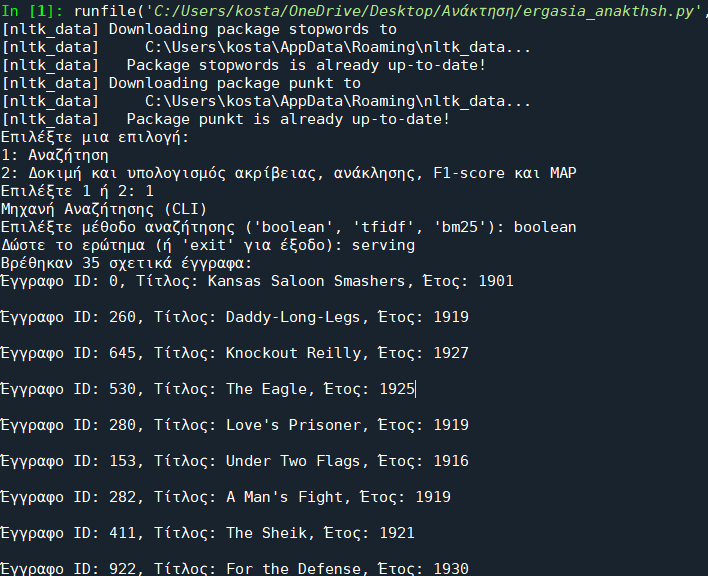

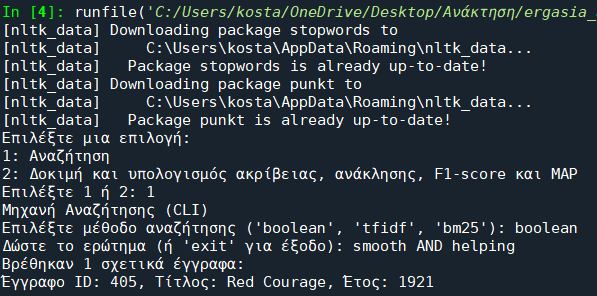

# β) Κατάταξη αποτελεσμάτων (Ranking):

- Οι μέθοδοι αναζήτησης TF-IDF και BM25 κατατάσουν τα έγγραφα με βάση την συνάφεια. 
Συγκεκριμένα υπολογίζουν τη σημασία μιας λέξης σε ένα έγγραφο, βασισμένη στη 
συχνότητά της στο έγγραφο και τη σπανιότητά της σε όλο το σύνολο εγγράφων.

- Το BM25 επηρεάζεται από το μήκος του εγγράφου και μειώνεται η επίδραση συχνών λέξεων, 
ενώ το TF-IDF βασίζεται στη συχνότητα λέξεων και την αντίστροφη συχνότητα τους.

In [ ]:
# TF-IDF Search
def tfidf_search(query, data):
    # Ένωση του dataset με το ερώτημα
    documents = data['Processed_Plot'].tolist()
    documents.append(preprocess_text_with_stemming(query))

    # Υπολογισμός των TF-IDF διανυσμάτων
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Υπολογισμός του cosine similarity
    cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1]).flatten()

    # Ταξινόμηση των εγγράφων βάσει ομοιότητας
    related_docs_indices = cosine_similarities.argsort()[::-1]

    # Επιστροφή των δεικτών των εγγράφων και της ομοιότητας του καθενός
    return [(index, cosine_similarities[index]) for index in related_docs_indices if cosine_similarities[index] > 0]

tokenized_corpus = [doc.split() for doc in data['Processed_Plot']]
bm25 = BM25Okapi(tokenized_corpus)

def bm25_search(query, data):
    #Tokenization
    query_tokens = word_tokenize(query.lower())
    #Stemming και φιλτράρισμα για stop words
    query_stemmed = [stemmer.stem(token) for token in query_tokens if token not in stopwords]
    #Υπολογισμός BM25 βαθμολογίας
    scores = bm25.get_scores(query_stemmed)
    #Ταξινόμηση των εγγράφων βάσει της βαθμολογίας
    ranked_results = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)
    return [(idx, score) for idx, score in ranked_results if score > 0]


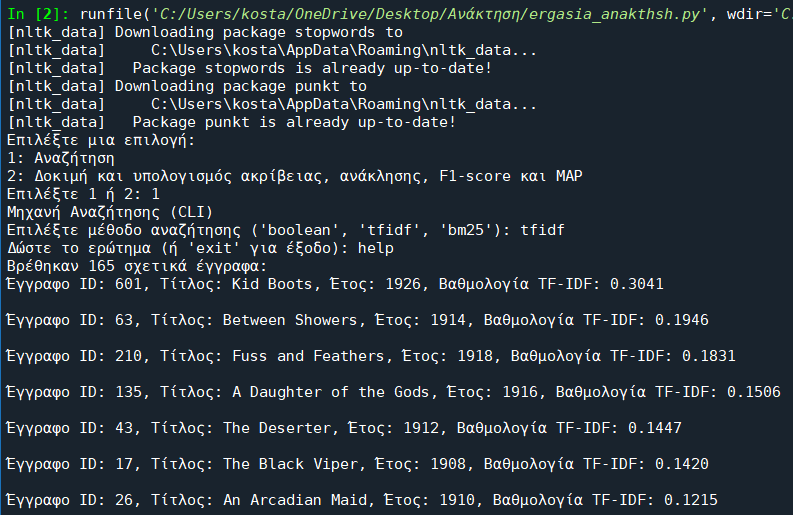

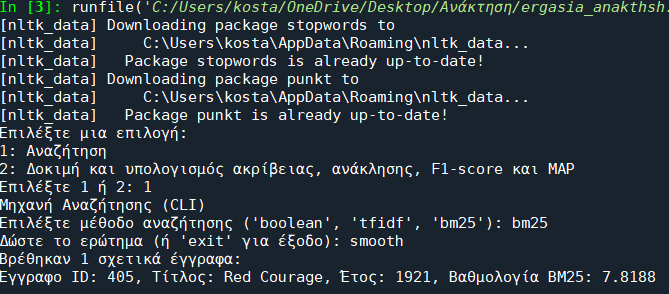

# Βήμα 5. Αξιολόγηση συστήματος:
- Η αξιολόγηση του συστήματος ανάκτησης γίνεται με την βοήθεια του CISI Dataset 
- Χρησιμοποιείται η τυποποιημένη βάση που φέρει 

# Χρήση CISI.QRY 
- Στην παρακάτω συνάρτηση φορτώνεται και επεξεργάζεται το αρχείο CISI.QRY σε ένα δομημένο λεξίκο. 
- Τα κλειδία είναι τα Query IDs και οι τιμές είναι τα αντίστοιχα κείμενα των ερωτήματων 

In [ ]:
def load_qry_file(filepath):
    queries = {}
    with open(filepath, 'r') as file:
        lines = file.readlines()
        current_query_id = None
        current_query_text = ""
        for line in lines:
            if line.startswith(".I"):
                if current_query_id is not None:
                    queries[current_query_id] = current_query_text.strip()
                current_query_id = int(line.split()[1])
                current_query_text = ""
            elif line.startswith(".W"):
                continue
            else:
                current_query_text += line.strip() + " "
        if current_query_id is not None:
            queries[current_query_id] = current_query_text.strip()
    # Έλεγχος αν το queries είναι άδειο
    if not queries:
        print("Σφάλμα: Το αρχείο ερωτημάτων είναι κενό ή δεν φορτώθηκε σωστά.")
    else:
        print(f"Φόρτωση ολοκληρώθηκε: {len(queries)} ερωτήματα.")
    return queries

# Φόρτωση και επεξεργασία των relevance judgments 
- Η συνάρτηση μετατρέπει το περιεχόμενο του αρχείου CISI.REL σε δομημένο λεξικό 
- Χρησιμοποιείται στην αξιολόγηση του συστήματος ανάκτησης και την σύγκριση των εγγράφων που ανακτήθηκαν με τα ground truth.

In [ ]:
def load_rel_file(filepath):
    relevance_info = {}
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 2:
                query_id = int(parts[0])
                doc_id = int(parts[1])
                if query_id not in relevance_info:
                    relevance_info[query_id] = []
                relevance_info[query_id].append(doc_id)
    # Έλεγχος αν το relevance_info είναι άδειο
   return relevance_info

# Φόρτωση και επεξεργασία του CISI.ALL
- Αντιστοιχίζεται κάθε έγγραφο σε ενα μονάδικό id

In [ ]:
def load_doc_file(file_path):
    documents = {}
    with open(file_path, 'r') as file:
        content = file.read().strip().split(".I")
        for item in content[1:]:
            lines = item.strip().split("\n")
            try:
                doc_id = int(lines[0].strip())  
            except ValueError:
                continue
            doc_text = " ".join(line.strip() for line in lines[1:])
            documents[doc_id] = doc_text
    return documents

# Δημιουργία ανεστραμένου ευρετηρίου
- Με κλειδιά τις μοναδικές λέξεις από τα έγγραφα και τις λίστες με τα ids των εγγράφων όπου εμφανίζεται η κάθε λέξη είναι δυνατή η γρήγορη ανάκτηση των εγγράφων με βάση λέξεων. 

In [ ]:
def create_inverted_index(data):
    inverted_index = defaultdict(list)
    for idx, row in data.iterrows(): 
        words = row['Processed_Plot'].split()
        for word in words:
            if idx not in inverted_index[word]:
                inverted_index[word].append(idx)
    return inverted_index

# Αξιολόγηση Συστήματος 
- Φορτώνονται τα ερωτήματα CISI.QRY και τα έγγραφα CISI.REL με αυτα υπολογίζονται για κάθε ερώτημα 
- Ακρίβεια , το ποσοστό σωστών ανακτήσεων σε σψέση με το σύνολο των σχετικών εγγράφων 
- Ανάκληση , το ποσοστό ανακτήσεων σε σχέση με το σύνολο των σχετικών εγγράφων 
- F1-Score, σταθμισμένος μέσος όρος ακρίβειας και ανάκλησης
- Μέση Ακρίβεια , ποσοτικοποίηση της συνολικής απόδοσης του συστήματος
- Τέλος εμφανίζονται τα συνολικά αποτελέσματα ανά αλγόριθμο για κάθε αλγόριθμο

In [ ]:
def user_choice():
    print("Επιλέξτε μια επιλογή:")
    print("1: Αναζήτηση")
    print("2: Δοκιμή και υπολογισμός ακρίβειας, ανάκλησης, F1-score και MAP")
    choice = input("Επιλέξτε 1 ή 2: ")

    if choice == '1':
        print("Μηχανή Αναζήτησης (CLI)")
        search_method = input("Επιλέξτε μέθοδο αναζήτησης ('boolean', 'tfidf', 'bm25'): ").strip().lower()
        
        while True:
            query = input("Δώστε το ερώτημα (ή 'exit' για έξοδο): ")
            if query.lower() == "exit":
                print("Έξοδος από τη μηχανή αναζήτησης.")
                break

            if search_method == 'boolean': 
                results = boolean_search(query, inverted_index)
                print(f"Βρέθηκαν {len(results)} σχετικά έγγραφα:")
                for idx in results:
                    title = data.loc[idx, 'Title']
                    release_year = data.loc[idx, 'Release Year']
                    print(f"Έγγραφο ID: {idx}, Τίτλος: {title}, Έτος: {release_year}\n")
            elif search_method == 'tfidf':
                results = tfidf_search(query, data)
                print(f"Βρέθηκαν {len(results)} σχετικά έγγραφα:")
                for idx, score in results:
                    title = data.loc[idx, 'Title']
                    release_year = data.loc[idx, 'Release Year']
                    print(f"Έγγραφο ID: {idx}, Τίτλος: {title}, Έτος: {release_year}, Βαθμολογία TF-IDF: {score:.4f}\n")
            elif search_method == 'bm25':
                results = bm25_search(query, data)
                print(f"Βρέθηκαν {len(results)} σχετικά έγγραφα:")
                for idx, score in results:
                    title = data.loc[idx, 'Title']
                    release_year = data.loc[idx, 'Release Year']
                    print(f"Έγγραφο ID: {idx}, Τίτλος: {title}, Έτος: {release_year}, Βαθμολογία BM25: {score:.4f}\n")
            else:
                print("Μη έγκυρη μέθοδος αναζήτησης. Παρακαλώ επιλέξτε 'boolean', 'tfidf', 'bm25'")
                break
            
    elif choice == '2':
        queries = load_qry_file('CISI.QRY')
        relevance_info = load_rel_file('CISI.REL')
        def evaluate_search_results(query_id, retrieved_docs, relevance_info):
            relevant_docs = set(relevance_info.get(query_id, []))
            retrieved_docs = set(retrieved_docs)
            
            # Ελέγξτε αν υπάρχουν σχετικά έγγραφα για το τρέχον ερώτημα
            if not relevant_docs:
                return 0.0, 0.0, 0.0, 0.0  # Επιστροφή μηδενικών τιμών αν δεν υπάρχουν σχετικά έγγραφα
        
            # Υπολογισμός Ακρίβειας, Ανάκλησης και F1 μόνο αν υπάρχουν ανακτηθέντα έγγραφα
            if not retrieved_docs:
                return 0.0, 0.0, 0.0, 0.0  # Επιστροφή μηδενικών τιμών αν δεν υπάρχουν ανακτηθέντα έγγραφα
        
            y_true = [1 if doc_id in relevant_docs else 0 for doc_id in retrieved_docs]
            y_pred = [1] * len(retrieved_docs)  # Όλα τα ανακτηθέντα έγγραφα προβλέπονται ως σχετικά
            
            # Υπολογισμός Ακρίβειας, Ανάκλησης και F1 μόνο αν υπάρχουν σχετικά έγγραφα
            precision = precision_score(y_true, y_pred, zero_division=0) if any(y_true) else 0.0
            recall = recall_score(y_true, y_pred, zero_division=0) if any(y_true) else 0.0
            f1 = f1_score(y_true, y_pred, zero_division=0) if any(y_true) else 0.0
            
            # Υπολογισμός Μέσης Ακρίβειας (AP) μόνο αν υπάρχουν ανακτηθέντα έγγραφα
            ap = average_precision_score(y_true, [1] * len(retrieved_docs)) if any(y_true) else 0.0
        
            return precision, recall, f1, ap

        def evaluate_all_queries(queries, relevance_info, data, search_method):
            total_precision = 0
            total_recall = 0
            total_f1 = 0
            total_ap = 0
            num_queries = len(queries)

            for query_id, query_text in queries.items():
                if search_method == 'boolean':
                    inverted_index = create_inverted_index(data)
                    retrieved_docs = list(boolean_search(query_text, inverted_index))
                elif search_method == 'tfidf':
                    retrieved_docs = [idx for idx, _ in tfidf_search(query_text, data)]
                elif search_method == 'bm25':
                    retrieved_docs = [idx for idx, _ in bm25_search(query_text, data)]
                else:
                    print("Μη έγκυρη μέθοδος αναζήτησης.")
                    continue

                precision, recall, f1, ap = evaluate_search_results(query_id, retrieved_docs, relevance_info)

                total_precision += precision
                total_recall += recall
                total_f1 += f1
                total_ap += ap

            # Υπολογισμός και εκτύπωση των συνολικών αποτελεσμάτων
            mean_precision = total_precision / num_queries
            mean_recall = total_recall / num_queries
            mean_f1 = total_f1 / num_queries
            mean_ap = total_ap / num_queries

            print(f"\nΣυνολική Αξιολόγηση {search_method}:")
            print(f"Μέση Ακρίβεια: {mean_precision:.4f}")
            print(f"Μέση Ανάκληση: {mean_recall:.4f}")
            print(f"Μέσος Όρος F1-Score: {mean_f1:.4f}")
            print(f"Μέση Ακρίβεια (MAP): {mean_ap:.4f}")

        search_method = "boolean"
        evaluate_all_queries(queries, relevance_info, data, search_method)
        search_method = "tfidf"
        evaluate_all_queries(queries, relevance_info, data, search_method)
        search_method = "bm25"
        evaluate_all_queries(queries, relevance_info, data, search_method)
        
    else:
        print("Ακατάλληλη επιλογή, προσπαθήστε ξανά.")
        user_choice()

user_choice()

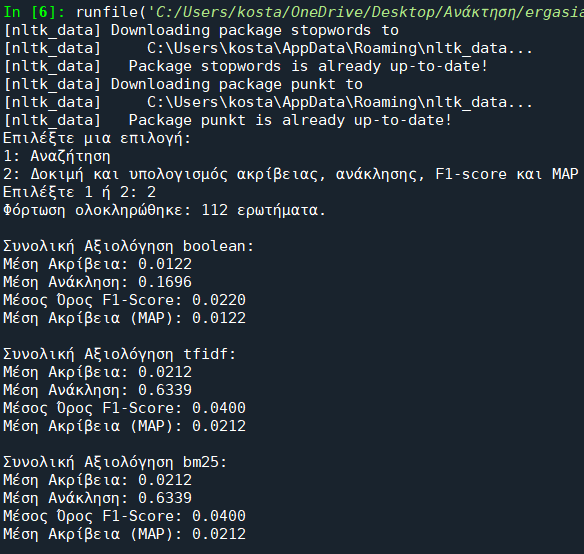